In [2]:
import torch
import math
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch import optim
import torchvision.transforms as T
from torch import Tensor
from torch import nn
import ipywidgets as widgets

In [6]:
noisy_imgs1, noisy_imgs2 = torch.load('../../data/train_data.pkl')
noisy_imgs_val, clear_imgs = torch.load('../../data/val_data.pkl')

<Figure size 432x288 with 0 Axes>

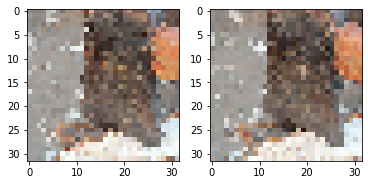

In [7]:
i=50
plt.figure()
#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(noisy_imgs1[i].permute(1,2,0))
axarr[1].imshow(noisy_imgs2[i].permute(1,2,0))

In [8]:
def psnr ( denoised , ground_truth ) :
    # Peak Signal to Noise Ratio : denoised and ground ̇truth have range [0 , 1]
    mse = torch.mean(( denoised - ground_truth ) ** 2)
    return -10 * torch.log10( mse + 10**-8)

In [9]:
from torch.nn.modules import padding
class mod(nn.Module):
    def __init__(self, 
                 skip_connections = True, batch_normalization = True):
        super().__init__()
        self.rel=nn.LeakyReLU(0.1)
        
        self.conv1 = nn.Conv2d(3, 3*4,
                               kernel_size = 8,
                               stride=2,
                               padding = 3)
        
        self.conv21 = nn.Conv2d(3*4, 3*6,
                               kernel_size = 6,
                               padding = 2)
        self.conv22 = nn.Conv2d(3*6, 3*12,
                               kernel_size = 6,
                               padding = 2)
        self.conv23 = nn.Conv2d(3*12, 3*12,
                               kernel_size = 4,
                               padding = 2)

        self.maxlong = nn.MaxPool2d(kernel_size=(3,1),padding=0)
        self.maxwide = nn.MaxPool2d(kernel_size=(1,3),padding=0)
        self.upwide = nn.Upsample(scale_factor=(1,3), mode='nearest')
        self.uplong = nn.Upsample(scale_factor=(3,1), mode='nearest')

        self.conv24 = nn.Conv2d(3*12, 3*4,
                               kernel_size = 2,
                               padding = 1)
        self.conv25 = nn.Conv2d(3*4, 3*4,
                               kernel_size = 5,
                               padding = 2)
        self.conv3 = nn.ConvTranspose2d(3*4, 3,
                                        kernel_size = 8,
                                        stride=2,
                                        padding = 3)
        self.m2=nn.Dropout(p=0.4)
        
    
    def load_pretrained_model(self) -> None:
        #if self.use_cuda:
        self.load_state_dict(torch.load('model.pt'))
        #else:
         #   self.model.load_state_dict(torch.load('model.pt', map_location='cpu'))
    
    
    def forward(self, x):
        y1 = self.conv1(x)
        y = self.m2(y1)
        y = self.conv21(y)
        y = self.rel(y)
        y = self.conv22(y)
        y = self.rel(y)
        y = self.conv23(y)
        ylong=self.maxlong(y)
        ywide=self.maxwide(y)
        y= self.upwide(ywide)+self.uplong(ylong)
        y= self.conv24(y)
        y=self.conv25(y)
        y=y+y1
        y=self.conv3(y)
        y = F.relu(y)
 
        return y

In [10]:
def train_model( train_input, train_target, mini_batch_size, nb_epochs = 100):
    device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss()
    model=mod()
    model=model.to(device)
    optim = torch.optim.Adam(model.parameters(), lr = 0.001)
    train_input, train_target = train_input.to(device).type(torch.float), train_target.to(device).type(torch.float)

    for e in range(nb_epochs):
        acc_loss = 0
        for b in range(0, train_input.size(0), mini_batch_size):
            optim.zero_grad()
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output/255, train_target.narrow(0, b, mini_batch_size)/255)
            acc_loss = acc_loss + loss.item()
            #print(output)
            loss.backward()
            torch.no_grad()
            optim.step()
        print(e, acc_loss,loss)
    return model

In [ ]:
mini_batch_size=100
model=train_model(noisy_imgs2,noisy_imgs1,mini_batch_size,75)

0 13.624463145621121 tensor(0.0177, grad_fn=<MseLossBackward0>)
1 8.423361998982728 tensor(0.0162, grad_fn=<MseLossBackward0>)
2 7.979088835418224 tensor(0.0158, grad_fn=<MseLossBackward0>)
3 7.80599117372185 tensor(0.0154, grad_fn=<MseLossBackward0>)
4 7.717972486279905 tensor(0.0154, grad_fn=<MseLossBackward0>)
5 7.664879143238068 tensor(0.0153, grad_fn=<MseLossBackward0>)
6 7.627597572281957 tensor(0.0152, grad_fn=<MseLossBackward0>)
7 7.600514333695173 tensor(0.0151, grad_fn=<MseLossBackward0>)
8 7.578515904024243 tensor(0.0151, grad_fn=<MseLossBackward0>)
9 7.561605892144144 tensor(0.0150, grad_fn=<MseLossBackward0>)


In [142]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.eval()
score=[]
i=0
clear_imgs=clear_imgs.to(device)
pred=model(noisy_imgs_val.to(device).type(torch.float))
for l in range (noisy_imgs_val.size()[0]):
    score.append(psnr(pred[l]/255,clear_imgs[l]/255).tolist())
import statistics
statistics.mean(score)

24.92333550643921

In [130]:
pred=pred.type(torch.int)

<Figure size 432x288 with 0 Axes>

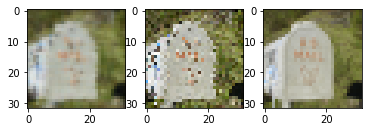

In [131]:
i=8

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,3) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(pred[i].permute(1,2,0))
axarr[1].imshow(noisy_imgs_val[i].permute(1,2,0))
axarr[2].imshow(clear_imgs[i].permute(1,2,0))

In [132]:
torch.save(model.state_dict(), 'model.pt')

In [141]:
model=mod()
model.load_pretrained_model()